# Extract Narrations and Audio Captions Tutorial

In this tutorial, you will be extracting video narrations through an auto-narration model, LaViLa, as well as audio captions through speech-to-text model, WhisperX. Finally, you will be able to interact with the extracted narrations and captions using langchain.

### Notebook stuck?
Note that because of Jupyter issues, sometimes the code may stuck at visualization. We recommend **restart the kernels** and try again to see if the issue is resolved.

## Step 1. Install Project Aria Tools
Run the following cell to install Project Aria Tools for reading Aria recordings in .vrs format

In [16]:
# Specifics for Google Colab
google_colab_env = 'google.colab' in str(get_ipython())
print("Running from Google Colab, installing projectaria_tools")
!pip install projectaria-tools

Running from Google Colab, installing projectaria_tools


## Step 2. Prepare an Aria recording

#### (Option 1) Download a sample data
We recommend running this tutorial with this small scale sample data first for testing out the dependencies.



In [ ]:
!curl -O -J -L "https://github.com/facebookresearch/projectaria_tools/raw/main/data/mps_sample/sample.vrs"
vrsfile = "sample.vrs"
print(f"INFO: vrsfile set to {vrsfile}")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 75.1M  100 75.1M    0     0   107M      0 --:--:-- --:--:-- --:--:--  107M
INFO: vrsfile set to sample.vrs


#### (Option 2) Prepare your collected Aria recording
We will set the vrsfile path to your collected Aria recording.

Upload your Aria recording in your Google Drive before running the cell.

Here, we assume it is uploaded to **`My Drive/aria/recording.vrs`**

*(You can check the content of the mounted drive by running `!ls "/content/drive/My Drive/"` in a cell.)*

In [ ]:
from google.colab import drive
import os
drive.flush_and_unmount()
drive.mount('/content/drive/')
my_vrs_file_path = 'aria/recording.vrs'
vrsfile = "/content/drive/My Drive/" + my_vrs_file_path
print(f"INFO: vrsfile set to {vrsfile}")

## Step 3. Create data provider

Create projectaria data_provider so you can load the content of the vrs file.

In [17]:
from projectaria_tools.core import data_provider, calibration
from projectaria_tools.core.sensor_data import TimeDomain, TimeQueryOptions
from projectaria_tools.core.stream_id import RecordableTypeId, StreamId
import numpy as np
from matplotlib import pyplot as plt

print(f"Creating data provider from {vrsfile}")
provider = data_provider.create_vrs_data_provider(vrsfile)
if not provider:
    print("Invalid vrs data provider")

Creating data provider from sample.vrs


## Step 4. Display VRS rgb content in thumbnail images

Goals:
- Summarize a VRS using 10 image side by side, to visually inspect the collected data.

Key learnings:
- Image streams are identified with a Unique Identifier: stream_id
- Image frames are identified with timestamps
- PIL images can be created from Numpy array

Customization
- To change the number of sampled images, change the variable `sample_count` to a desired number.
- To change the thumbnail size, change the variable `resize_ratio` to a desired value.

100%|██████████| 10/10 [00:00<00:00, 11.17it/s]


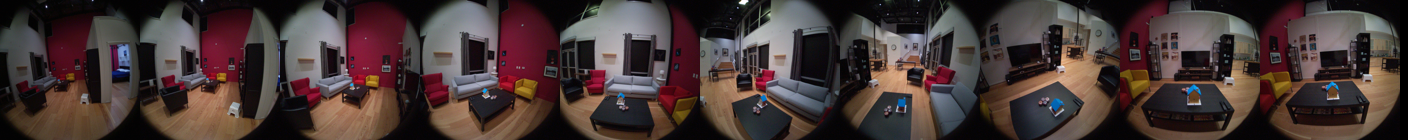

In [18]:
from PIL import Image
from tqdm import tqdm

sample_count = 10
resize_ratio = 10

rgb_stream_id = StreamId("214-1")

# Retrieve image size for the RGB stream
time_domain = TimeDomain.DEVICE_TIME  # query data based on host time
option = TimeQueryOptions.CLOSEST # get data whose time [in TimeDomain] is CLOSEST to query time

# Retrieve Start and End time for the given Sensor Stream Id
start_time = provider.get_first_time_ns(rgb_stream_id, time_domain)
end_time = provider.get_last_time_ns(rgb_stream_id, time_domain)

image_config = provider.get_image_configuration(rgb_stream_id)
width = image_config.image_width
height = image_config.image_height

thumbnail = newImage = Image.new(
    "RGB", (int(width * sample_count / resize_ratio), int(height / resize_ratio))
)
current_width = 0


# Samples 10 timestamps
sample_timestamps = np.linspace(start_time, end_time, sample_count)
for sample in tqdm(sample_timestamps):
    image_tuple = provider.get_image_data_by_time_ns(rgb_stream_id, int(sample), time_domain, option)
    image_array = image_tuple[0].to_numpy_array()
    image = Image.fromarray(image_array)
    new_size = (
        int(image.size[0] / resize_ratio),
        int(image.size[1] / resize_ratio),
    )
    image = image.resize(new_size).rotate(-90)
    thumbnail.paste(image, (current_width, 0))
    current_width = int(current_width + width / resize_ratio)

from IPython.display import Image
display(thumbnail)

## Step 5. Prepare Pytorch Data Loader for Auto-Narration

Here, we will be creating a pytorch data loader that outputs batches of video snippets in order to run the LaViLa auto-narration model.

A **snippet** consists of a series of frames captured over a brief time span, which we will refer to as **snippet duration**.

#### Step 5-1. Define Dataset

In [19]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import torch.nn as nn

class RGBDataset(Dataset):
    def __init__(self, start_time, end_time, sample_count, transform=None):
        self.timestamps = np.linspace(start_time, end_time, sample_count)
        self.rgb_stream_id = StreamId("214-1")
        self.time_domain = TimeDomain.DEVICE_TIME
        self.option = TimeQueryOptions.CLOSEST
        self.transform = transform

    def __len__(self):
        return len(self.timestamps)

    def __getitem__(self, idx):
        timestamp = self.timestamps[idx]
        image_tuple = provider.get_image_data_by_time_ns(self.rgb_stream_id, int(timestamp), self.time_domain, self.option)
        image_array = image_tuple[0].to_numpy_array()
        image = Image.fromarray(image_array).rotate(-90)
        if self.transform:
          image = self.transform(image)
        return timestamp, image

val_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
  ])

rgb_dataset = RGBDataset(start_time, end_time, sample_count, transform=val_transform)
image_dataloader = DataLoader(rgb_dataset, batch_size=2, shuffle=False)
# Get the next batch of data
timestamp, image = next(iter(image_dataloader))

## Install DETIC

In [20]:
# Install detectron2
import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# Use the below line to install detectron2 if the above one has an error
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git@v0.6'

torch:  2.1 ; cuda:  cu118
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu118/torch2.1/index.html


In [21]:
# clone and install Detic
!git clone https://github.com/facebookresearch/Detic.git --recurse-submodules
%cd Detic
!pip install -r requirements.txt

Cloning into 'Detic'...
remote: Enumerating objects: 210, done.
remote: Counting objects: 100% (115/115), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 210 (delta 58), reused 46 (delta 43), pack-reused 95
Receiving objects: 100% (210/210), 3.59 MiB | 26.04 MiB/s, done.
Resolving deltas: 100% (81/81), done.
Submodule 'third_party/CenterNet2' (https://github.com/xingyizhou/CenterNet2.git) registered for path 'third_party/CenterNet2'
Submodule 'third_party/Deformable-DETR' (https://github.com/fundamentalvision/Deformable-DETR.git) registered for path 'third_party/Deformable-DETR'
Cloning into '/content/Detic/third_party/CenterNet2'...
remote: Enumerating objects: 13925, done.        
remote: Counting objects: 100% (813/813), done.        
remote: Compressing objects: 100% (80/80), done.        
remote: Total 13925 (delta 760), reused 739 (delta 731), pack-reused 13112        
Receiving objects: 100% (13925/13925), 5.08 MiB | 6.90 MiB/s, done.
Resolving deltas: 100% 

In [26]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import sys
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Detic libraries
sys.path.insert(0, 'third_party/CenterNet2')
from centernet.config import add_centernet_config
from detic.config import add_detic_config
from detic.modeling.utils import reset_cls_test

In [27]:
# Build the detector and download our pretrained weights
cfg = get_cfg()
add_centernet_config(cfg)
add_detic_config(cfg)
cfg.merge_from_file("configs/Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.yaml")
cfg.MODEL.WEIGHTS = 'https://dl.fbaipublicfiles.com/detic/Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.pth'
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
cfg.MODEL.ROI_BOX_HEAD.ZEROSHOT_WEIGHT_PATH = 'rand'
cfg.MODEL.ROI_HEADS.ONE_CLASS_PER_PROPOSAL = True # For better visualization purpose. Set to False for all classes.
# cfg.MODEL.DEVICE='cpu' # uncomment this to use cpu-only mode.
predictor = DefaultPredictor(cfg)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[10/23 17:45:24 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detic/Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.pth ...


Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.pth: 702MB [00:35, 20.1MB/s]                           


In [28]:
# Setup the model's vocabulary using build-in datasets

BUILDIN_CLASSIFIER = {
    'lvis': 'datasets/metadata/lvis_v1_clip_a+cname.npy',
    'objects365': 'datasets/metadata/o365_clip_a+cnamefix.npy',
    'openimages': 'datasets/metadata/oid_clip_a+cname.npy',
    'coco': 'datasets/metadata/coco_clip_a+cname.npy',
}

BUILDIN_METADATA_PATH = {
    'lvis': 'lvis_v1_val',
    'objects365': 'objects365_v2_val',
    'openimages': 'oid_val_expanded',
    'coco': 'coco_2017_val',
}

vocabulary = 'lvis' # change to 'lvis', 'objects365', 'openimages', or 'coco'
metadata = MetadataCatalog.get(BUILDIN_METADATA_PATH[vocabulary])
classifier = BUILDIN_CLASSIFIER[vocabulary]
num_classes = len(metadata.thing_classes)
reset_cls_test(predictor.model, classifier, num_classes)

Resetting zs_weight datasets/metadata/lvis_v1_clip_a+cname.npy


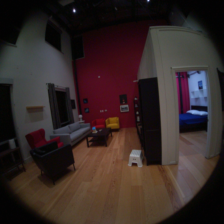

In [40]:
# Download a sample image and display. Replace path here to try your own images!
# !wget https://web.eecs.umich.edu/~fouhey/fun/desk/desk.jpg
# im = cv2.imread("./desk.jpg")
image_np = image[0].squeeze(0).numpy().transpose(1, 2, 0) * 256

# Convert RGB to BGR
image_bgr = cv2.cvtColor(image_np.astype('uint8'), cv2.COLOR_RGB2BGR)
cv2_imshow(image_bgr)

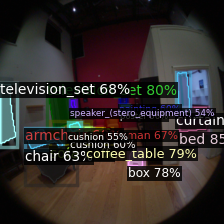

In [41]:
# Run model and show results
outputs = predictor(image_bgr)
v = Visualizer(image_bgr[:, :, ::-1], metadata)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

## Step 15. Install Langchain

In [ ]:
!pip install langchain

## Step 16. Install OpenAI to use with Langchain

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip install openai

## Step 17. Summaraize the narration result


In [ ]:
from langchain.chat_models import ChatOpenAI
from langchain.chains.summarize import load_summarize_chain
from langchain.docstore.document import Document
from langchain.document_loaders.csv_loader import CSVLoader
from langchain import PromptTemplate


prompt_template = """ Write a concise summary (between 5 to 10 sentences) of the following text.
The text is about my exhaustive timeline, where I am referred to as '#C C' or 'C C' or 'C'.
Please use first person pronoun (I) in the summary, instead of 'C' or 'C C'.
Please keep in mind that some observations maybe incorrect as the timeline was machine-generated.

Timeline:

{text}


TL'DR: """

#os.environ["OPENAI_API_KEY"] = "sk-your-key"
PROMPT = PromptTemplate(template=prompt_template, input_variables=["text"])
llm = ChatOpenAI(temperature=0, model_name="gpt-3.5-turbo")
chain = load_summarize_chain(llm, chain_type="stuff")

loader = CSVLoader(file_path=narration_save_path)
docs = loader.load()

chain.run(docs)

'The summary describes a series of events with timestamps and corresponding narrations. The events involve a character named C C who is observed looking around, adjusting the camera, staring at the ceiling, standing beside the door, and looking at various objects in the room and house.'

## (Optional) RGBDataset

The RGBDataset is a simple image pytorch dataset designed for image-based models that operate on individual frames rather than snippet inputs. Use this dataset that process single frames.